In [ ]:
!pip install tensorflow==2.9.1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


DATA PREPROCESSING

In [ ]:
import zipfile
import os

# Path to the zip file
zip_file_path = '/content/drive/MyDrive/CNN/6 Senjata Tradisional di Jawa Barat.zip'

# Directory to extract the contents
extracted_dir = '/content/'

# Create the extraction directory if it doesn't exist
os.makedirs(extracted_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

print(f"Successfully extracted contents to {extracted_dir}")

Successfully extracted contents to /content/


In [ ]:
# Generate data paths with labels
data_dir = '/content/6 Senjata Tradisional di Jawa Barat'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
df

,filepaths,labels
0,/content/6 Senjata Tradisional di Jawa Barat/A...,Arit
1,/content/6 Senjata Tradisional di Jawa Barat/A...,Arit
2,/content/6 Senjata Tradisional di Jawa Barat/A...,Arit
3,/content/6 Senjata Tradisional di Jawa Barat/A...,Arit
4,/content/6 Senjata Tradisional di Jawa Barat/A...,Arit
...,...,...
805,/content/6 Senjata Tradisional di Jawa Barat/P...,Patik
806,/content/6 Senjata Tradisional di Jawa Barat/P...,Patik
807,/content/6 Senjata Tradisional di Jawa Barat/P...,Patik
808,/content/6 Senjata Tradisional di Jawa Barat/P...,Patik


### **Split dataframe into train, valid, and test**

In [ ]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

### **Create image data generator**

In [ ]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 643 validated image filenames belonging to 5 classes.
Found 97 validated image filenames belonging to 5 classes.
Found 64 validated image filenames belonging to 5 classes.


### **Show sample from train data**

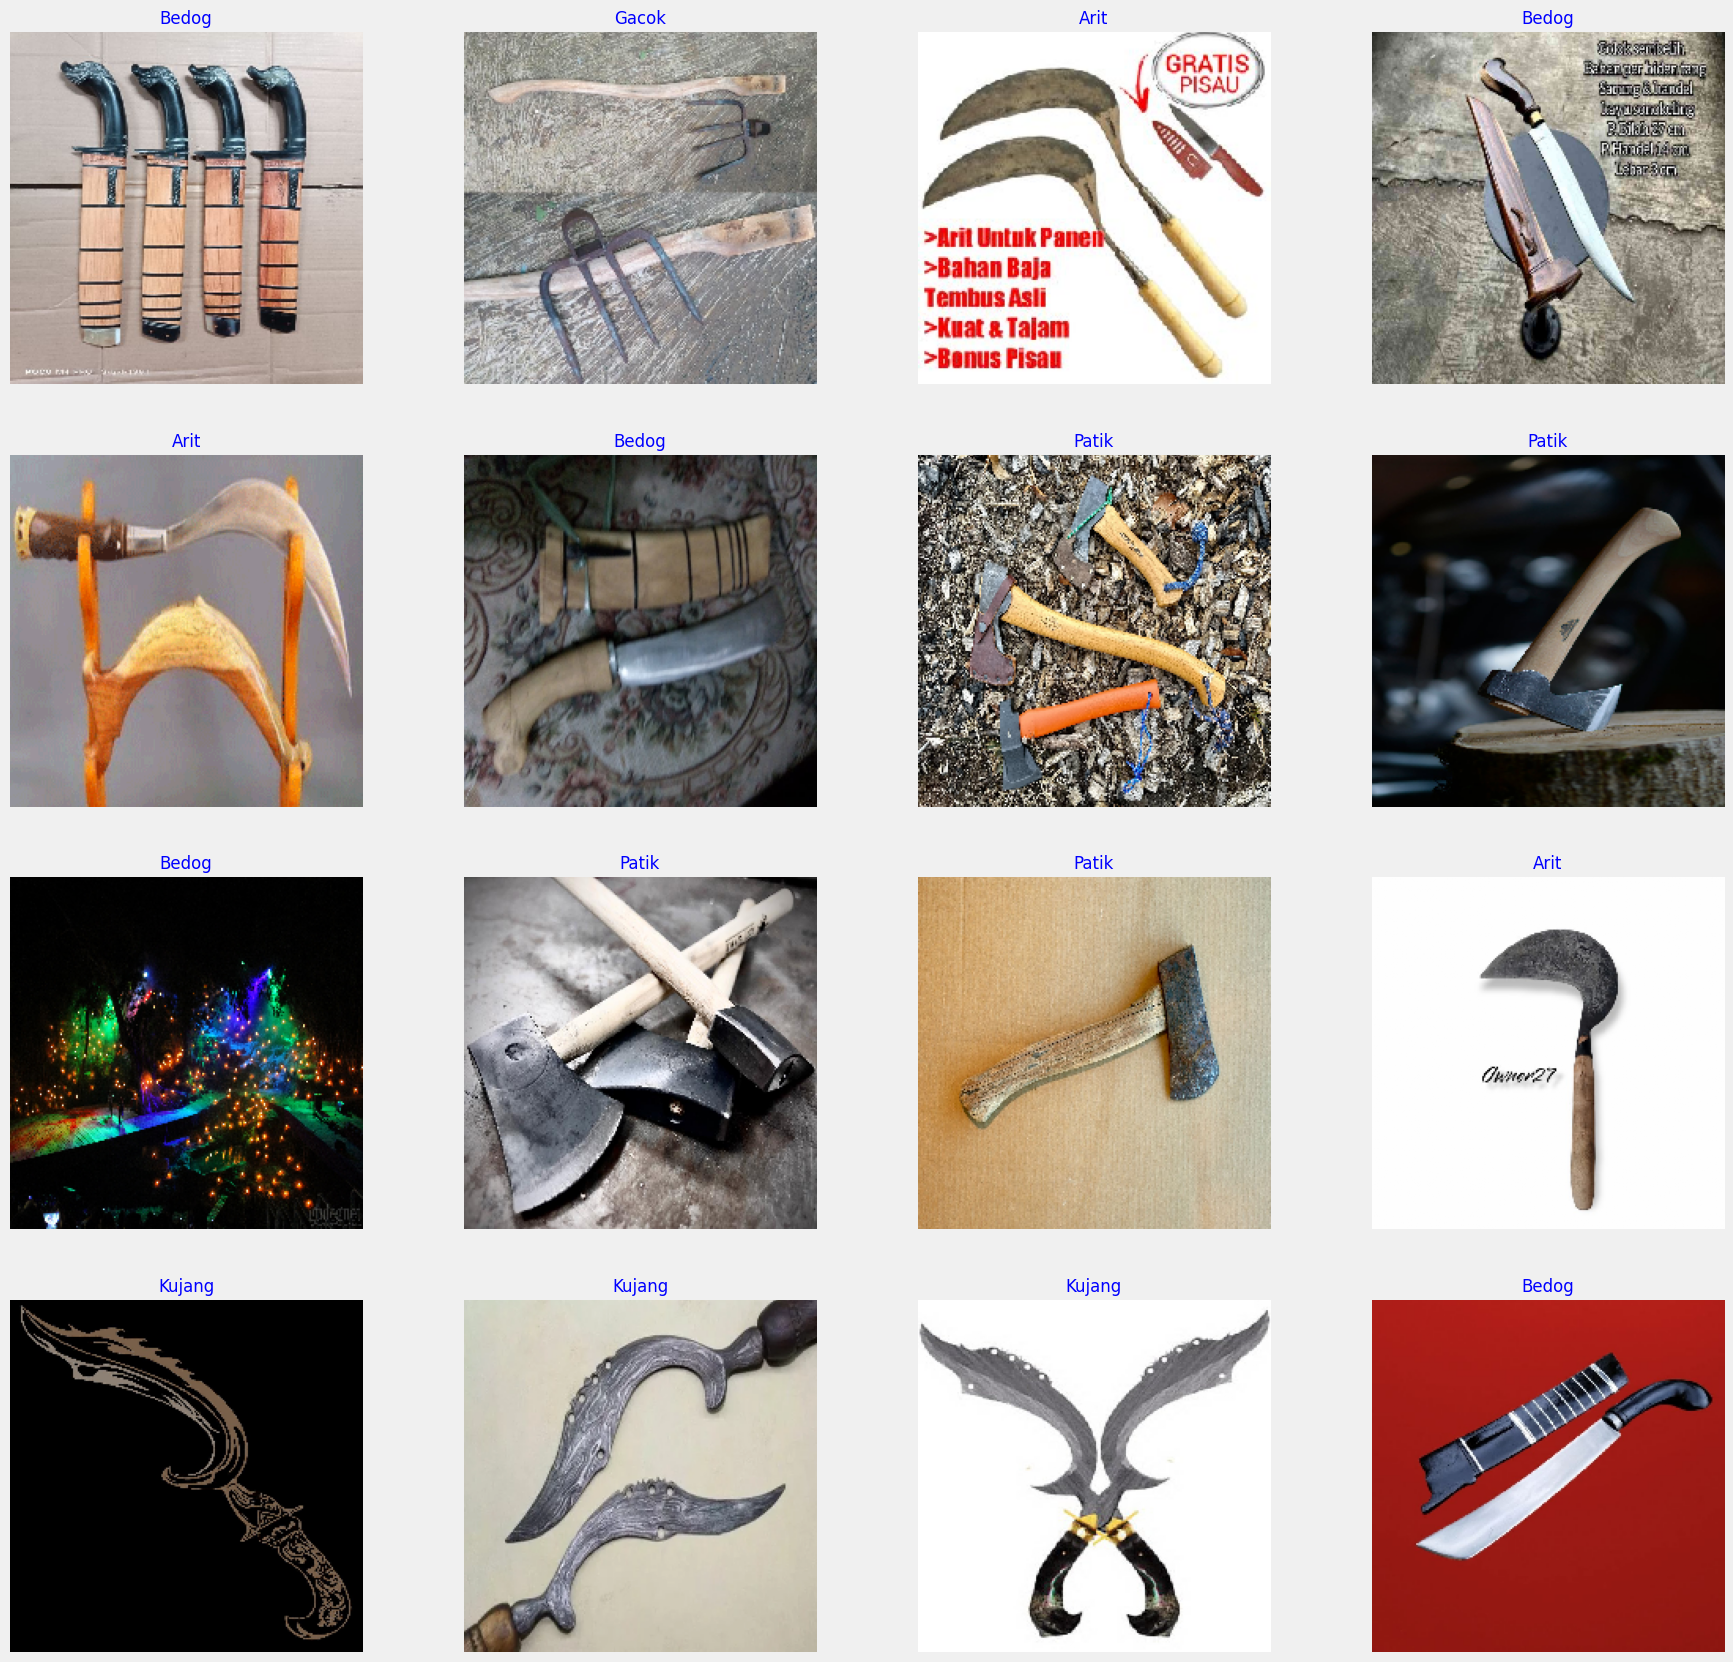

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

#### **Data Augmentation**

In [ ]:
data_augmentation = keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.4),
  tf.keras.layers.RandomZoom(0.1),
])

plt.figure(figsize=(8, 7))
for i in range(6):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(2, 3, i + 1)
  plt.imshow(augmented_image.numpy()/255)
  plt.axis("off")

# **Model Structure**

#### **Generic Model Creation**

In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization_4 (Bat  (None, 1280)              5120      
 chNormalization)                                                
                                                                 
 dense_8 (Dense)             (None, 256)               327936    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 4383912 (16.72 MB)
Trainable params: 433

#### **Train model**

In [ ]:
batch_size = 16   # set batch size for training
epochs = 75   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/75
41/41 [==============================] - 40s 274ms/step - loss: 8.2832 - accuracy: 0.6843 - val_loss: 8.6763 - val_accuracy: 0.8454
Epoch 2/75
41/41 [==============================] - 10s 252ms/step - loss: 7.0700 - accuracy: 0.9331 - val_loss: 7.6440 - val_accuracy: 0.9278
Epoch 3/75
41/41 [==============================] - 9s 214ms/step - loss: 6.4783 - accuracy: 0.9611 - val_loss: 6.7024 - val_accuracy: 0.9381
Epoch 4/75
41/41 [==============================] - 10s 240ms/step - loss: 5.9876 - accuracy: 0.9705 - val_loss: 6.0531 - val_accuracy: 0.9485
Epoch 5/75
41/41 [==============================] - 10s 248ms/step - loss: 5.5689 - accuracy: 0.9798 - val_loss: 5.5940 - val_accuracy: 0.9485
Epoch 6/75
41/41 [==============================] - 9s 225ms/step - loss: 5.1923 - accuracy: 0.9798 - val_loss: 5.1803 - val_accuracy: 0.9485
Epoch 7/75
41/41 [==============================] - 10s 252ms/step - loss: 4.8594 - accuracy: 0.9829 - val_loss: 4.8320 - val_accuracy: 0.9485
E

#### **Display model performance**

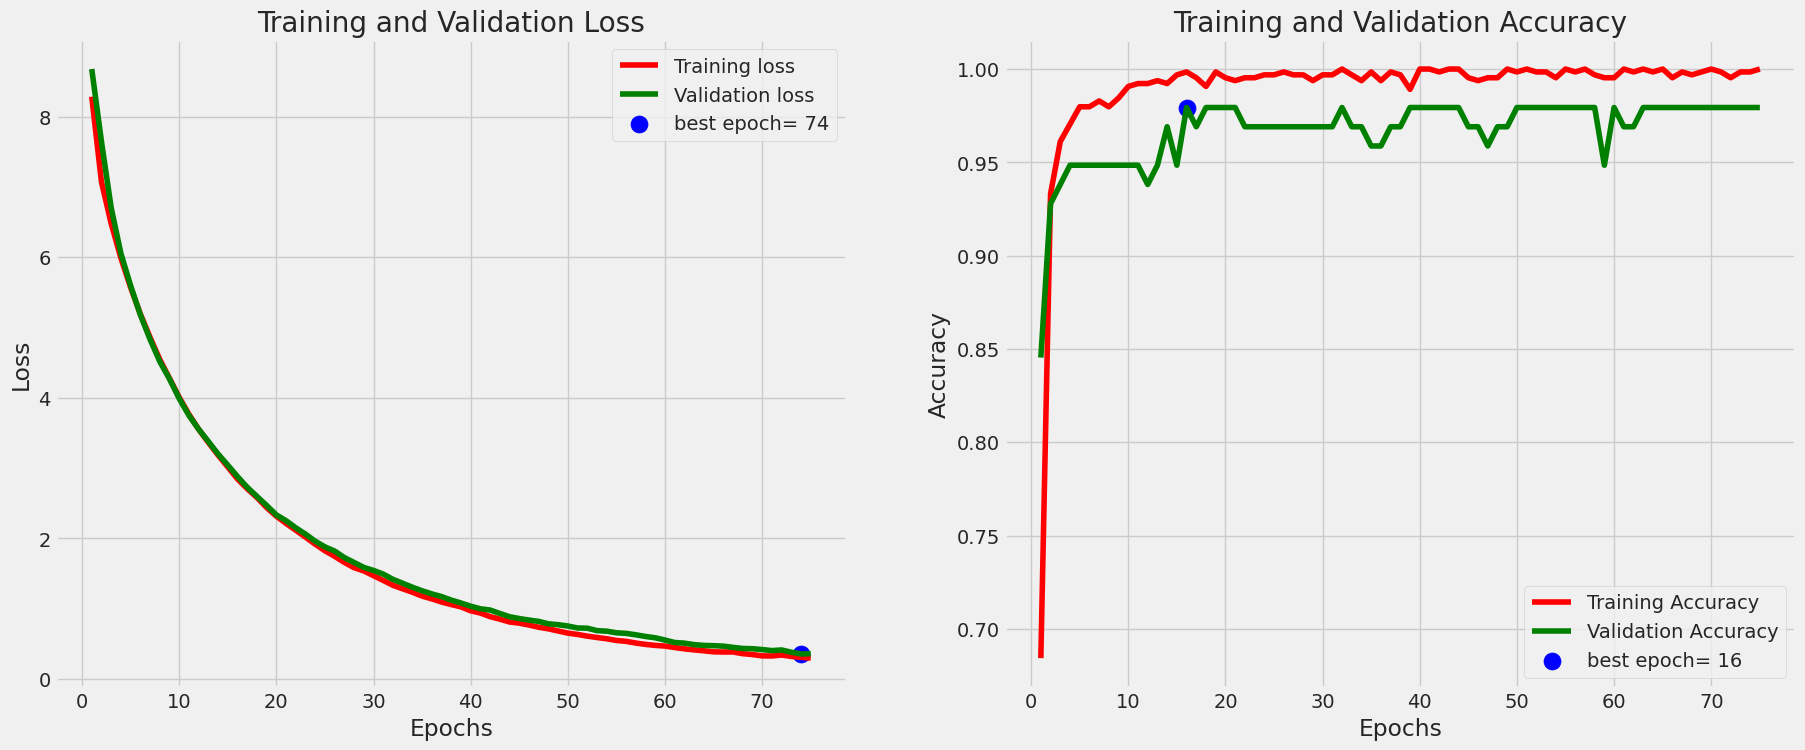

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# **Evaluate model**

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 [==============================] - 1s 1s/step - loss: 0.3668 - accuracy: 0.9844
Train Loss:  0.2656753659248352
Train Accuracy:  1.0
--------------------
Validation Loss:  0.3385777771472931
Validation Accuracy:  1.0
--------------------
Test Loss:  0.3667634129524231
Test Accuracy:  0.984375


# **Get Predictions**

In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

#### **Confusion Matrics and Classification Report**

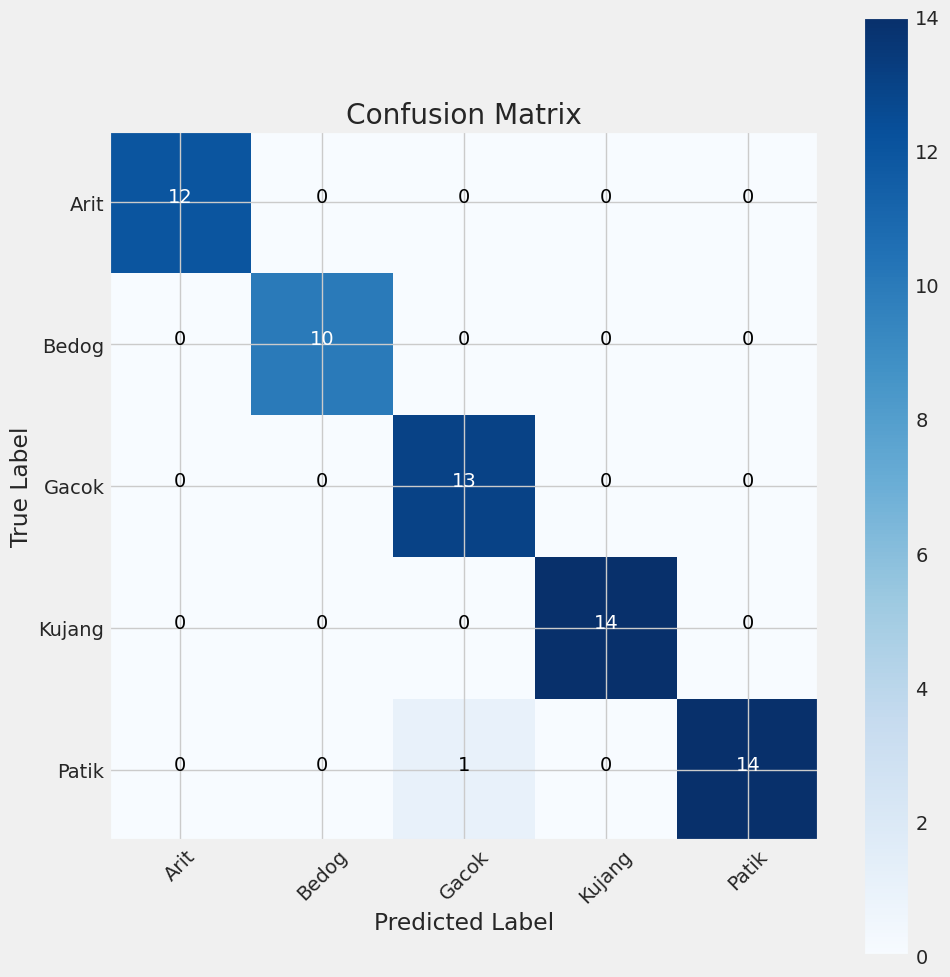

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

        Arit       1.00      1.00      1.00        12
       Bedog       1.00      1.00      1.00        10
       Gacok       0.93      1.00      0.96        13
      Kujang       1.00      1.00      1.00        14
       Patik       1.00      0.93      0.97        15

    accuracy                           0.98        64
   macro avg       0.99      0.99      0.99        64
weighted avg       0.99      0.98      0.98        64



#### **Save model**

In [ ]:
model_name = model.input_names[0][:-6]
subject = 'Mango Diseases'
acc = test_score[1] * 100
save_path = ''

# Save model
save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save weights
weight_save_id = str(f'{model_name}-{subject}-weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

model was saved as efficientnetb0-Mango Diseases-98.44.h5
weights were saved as efficientnetb0-Mango Diseases-weights.h5


#### **Generate CSV files containing classes indicies & image size**

In [ ]:
class_dict = train_gen.class_indices
img_size = train_gen.image_shape
height = []
width = []
for _ in range(len(class_dict)):
    height.append(img_size[0])
    width.append(img_size[1])

Index_series = pd.Series(list(class_dict.values()), name= 'class_index')
Class_series = pd.Series(list(class_dict.keys()), name= 'class')
Height_series = pd.Series(height, name= 'height')
Width_series = pd.Series(width, name= 'width')
class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis= 1)
csv_name = f'{subject}-class_dict.csv'
csv_save_loc = os.path.join(save_path, csv_name)
class_df.to_csv(csv_save_loc, index= False)
print(f'class csv file was saved as {csv_save_loc}')

class csv file was saved as Mango Diseases-class_dict.csv


In [ ]:
# @title Transfer Learning MobileNetV2
import tensorflow as tf
import os
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        val_accuracy = logs.get('val_accuracy')
        accuracy = logs.get('accuracy')
        if val_accuracy is not None and accuracy is not None and (val_accuracy >= 0.98 and accuracy >= 0.98):
            print("\nReached %2.2f%% validation accuracy, so stopping training!!" % (val_accuracy * 100))
            self.model.stop_training = True

callbacks = myCallback()

def Train():
    BASE_DIR = '/content/Klasifikasi 6 Senjata Tradisional di Jawa Barat'
    train_dir = os.path.join(BASE_DIR, 'TRAIN')
    test_dir = os.path.join(BASE_DIR, 'TEST')

    # NORMALIZE YOUR IMAGE HERE
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=16,
        class_mode='sparse'  # Change to 'sparse' for sparse categorical
    )

    test_datagen = ImageDataGenerator(rescale=1./255)  # No need for augmentation in test data
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=16,
        class_mode='sparse'  # Change to 'sparse' for sparse categorical
    )


    # DEFINE YOUR MODEL HERE
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    base_model.trainable = False

    # Attach a classification layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    # x = Dropout(0.5)(x)
    predictions = Dense(6, activation='softmax')(x)

    # Create a new model
    model = Model(inputs=base_model.input, outputs=predictions)

    # COMPILE MODEL HERE
    model.compile(optimizer=Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # TRAIN YOUR MODEL HERE
    model.fit(train_generator, epochs=100, validation_data=test_generator, callbacks=[callbacks])
    return model

# The code below is to save your model as a .h5 file.
# It will be saved automatically in your Submission folder.
if __name__ == '__main__':
    # DO NOT CHANGE THIS CODE
    model = Train()
    model.save("Model.h5")